In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

# some vectorizers
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for creating a baseline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import json
import torch
import torch.nn as nn

%matplotlib inline

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions_altered.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

In [3]:
df.head()

,text,confirmed,suggested,labels
0,Slut på medicin.,"[89, 651]",[348],"[Känd astma, Känd lungsjukdom]"
1,Ångest,[],[118],[]
2,"Tänkte bara höra med Er, när jag har möjlighet...",[],"[89, 913]",[]
3,Behöver att prata med psykolog angående använd...,"[116, 215]","[215, 348, 446]","[Nedstämdhet, Trötthet]"
4,Har fått besvärlig eksem på händerna,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"


In [4]:
# functions for preprocessing
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

In [5]:
# create X matrix
texts = df['text'].tolist()

for i in range(len(texts)):
    texts[i] = clean_text(texts[i])
    
v = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
X = v.fit_transform(texts).todense()

In [6]:
# create y matrix (labels)
labels = df['labels'].tolist()

multilab_bin = MultiLabelBinarizer()
y = multilab_bin.fit_transform(labels)

In [7]:
# turn X and y into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# matrix info
x_nnz = torch.count_nonzero(X)
y_nnz = torch.count_nonzero(y)

print(f'X: {X.shape[0]} x {X.shape[1]} matrix\t | {(x_nnz / (X.shape[0]*X.shape[1])) * 100:.3f} % nonzero elements')
print(f'y: {y.shape[0]} x {y.shape[1]} matrix\t | {(y_nnz / (y.shape[0]*y.shape[1])) * 100:.3f} % nonzero elements')

X: 4653 x 10000 matrix	 | 0.305 % nonzero elements
y: 4653 x 197 matrix	 | 0.826 % nonzero elements


In [8]:
# define the NN

# single-layered NN
class Net1(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(D_in, H1)
        self.fc2 = nn.Linear(H1, D_out)
        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigm(x)
        return x

# multi-layered NN
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, D_out)
        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigm(x)
        return x

In [9]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1


In [10]:
# prepare the data for the training and test
batch_size = 64

# add a column in y that keeps track of the index of the corresponding text
# make sure to handle it later
y = torch.cat((torch.tensor([i for i in range(y.shape[0])]).view(-1,1), y),1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    shuffle=True)

# create datasets. (do not include the index added above in y)
train_set = torch.utils.data.TensorDataset(X_train, y_train[:,1:])
test_set = torch.utils.data.TensorDataset(X_test, y_test[:,1:])

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True
                                          )
# might be unnecessary to use a loader for the test set right now
test_loader = torch.utils.data.DataLoader(dataset=train_set,
                                         batch_size=batch_size,
                                         shuffle=True)

In [11]:
# define the model
D_in, H1, H2, D_out = X.shape[1], 1000, 1000, y.shape[1]-1

model = Net1(D_in, H1, D_out)
model = model.to(device)


# training loop
learning_rate = 0.0004

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # save the losses
    model = model.to(torch.device('cpu'))
    
    y_pred_train = model(X_train)
    temp_loss = criterion(y_pred_train, y_train[:,1:])
    train_losses.append(temp_loss)
    
    y_pred_test = model(X_test)
    temp_loss = criterion(y_pred_test, y_test[:,1:])
    test_losses.append(temp_loss)
    
    model = model.to(device)
    
    
    
    print(f'End of epoch {epoch+1}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')

End of epoch 1, Train Loss: 0.1684514, Test Loss: 0.1717182
End of epoch 2, Train Loss: 0.0570007, Test Loss: 0.0585959
End of epoch 3, Train Loss: 0.0457722, Test Loss: 0.0471033
End of epoch 4, Train Loss: 0.0416739, Test Loss: 0.0429863
End of epoch 5, Train Loss: 0.0391534, Test Loss: 0.0405667
End of epoch 6, Train Loss: 0.0371815, Test Loss: 0.0387484
End of epoch 7, Train Loss: 0.0354168, Test Loss: 0.0372103
End of epoch 8, Train Loss: 0.0338037, Test Loss: 0.0358356
End of epoch 9, Train Loss: 0.0322700, Test Loss: 0.0345640
End of epoch 10, Train Loss: 0.0308262, Test Loss: 0.0334001
End of epoch 11, Train Loss: 0.0295093, Test Loss: 0.0323547
End of epoch 12, Train Loss: 0.0283289, Test Loss: 0.0314607
End of epoch 13, Train Loss: 0.0272760, Test Loss: 0.0306979
End of epoch 14, Train Loss: 0.0262702, Test Loss: 0.0300268
End of epoch 15, Train Loss: 0.0253302, Test Loss: 0.0294219
End of epoch 16, Train Loss: 0.0243805, Test Loss: 0.0288315
End of epoch 17, Train Loss: 0.02

Micro-average F1-score: 0.5057019268580416
Weighted-average F1-score: 0.39694330381140086
Sample-average Jaccard score: 0.4063732692894884
Accuracy (exact match): 0.2964554242749731
Hamming Loss: 0.006853609731362489


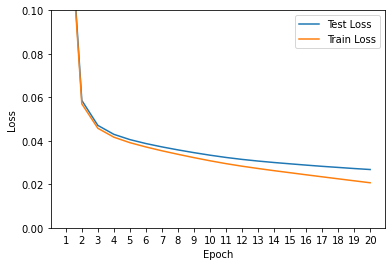

In [12]:
model = model.to(torch.device('cpu'))
y_pred = model(X_test).detach().numpy()
#y_pred = y_pred.cpu().detach().numpy()

# set all values above threshold to 1, else 0
th = 0.2
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

print(f"Micro-average F1-score: {f1_score(y_test[:,1:], y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_test[:,1:], y_pred, average='weighted', zero_division=1)}")
print(f"Sample-average Jaccard score: {jaccard_score(y_test[:,1:], y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_test[:,1:], y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_test[:,1:], y_pred)}")

x = [x for x in range(1,num_epochs+1)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(x, x)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().set_ylim([0,0.1])
plt.show()

In [ ]:
# find the 'per' % best/worst samples in the test-set w.r.t. BCE-loss
per = 2

loss_sorted = []

for i in range(y_test.shape[0]):
    y_pred = model(X_test[i,:])
    y_pred = y_pred.detach()
    loss = criterion(y_pred, y_test[i,1:])
    loss_sorted.append((loss, y_pred, y_test[i,:]))
    
loss_sorted = sorted(loss_sorted, key=lambda tup: tup[0])

nbr_elems = (len(loss_sorted) * per) // 100
min_loss = loss_sorted[:nbr_elems]
max_loss = loss_sorted[len(loss_sorted)-nbr_elems:]

In [ ]:
# print the top 'per' % best samples
for i in range(len(min_loss)):
    loss, y_pred, y_test_row = min_loss[i]
    
    # turn y_pred into binary (threshold th defined above)
    y_pred[y_pred > th] = 1
    y_pred[y_pred <= th] = 0
    
    y_pred_syms = multilab_bin.inverse_transform(y_pred.view(1,-1))
    y_test_syms = multilab_bin.inverse_transform(y_test_row[1:].view(1,-1))
    
    print(f'Loss: {loss}')
    print(f'{df["text"][int(y_test_row[0])]}')
    print(f'Prediction:\t {y_pred_syms}')
    print(f'Labels:\t\t {y_test_syms}')
    print('- - - - - - - - - - - - - -')

In [ ]:
# print the top 'per' % worst samples
for i in range(len(max_loss)):
    loss, y_pred, y_test_row = max_loss[i]
    
    # turn y_pred into binary (threshold th defined above)
    y_pred[y_pred > th] = 1
    y_pred[y_pred <= th] = 0
    
    y_pred_syms = multilab_bin.inverse_transform(y_pred.view(1,-1))
    y_test_syms = multilab_bin.inverse_transform(y_test_row[1:].view(1,-1))
    
    print(f'Loss: {loss}')
    print(f'{df["text"][int(y_test_row[0])]}')
    print(f'Prediction:\t {y_pred_syms}')
    print(f'Labels:\t\t {y_test_syms}')
    print('- - - - - - - - - - - - - -')

In [ ]:
# simple classifier used as a baseline
#clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
#clf.fit(X_train, y_train[:,1:])

In [ ]:
if False:
    y_pred_test_bl = clf.predict(X_test)
    y_pred_train_bl = clf.predict(X_train)

    bl_test_loss = criterion(torch.tensor(y_pred_test_bl, dtype=torch.float), y_test[:,1:])
    bl_train_loss = criterion(torch.tensor(y_pred_train_bl, dtype=torch.float), y_train[:,1:])

    print("Baseline metrics")
    print(f"Micro-average F1-score for baseline: {f1_score(y_test[:,1:], y_pred_test_bl, average='micro')}")
    print(f"Sample-average Jaccard score: {jaccard_score(y_test[:,1:], y_pred_test_bl, average='samples', zero_division=1)}")
    print(f"Accuracy (exact match): {accuracy_score(y_test[:,1:], y_pred_test_bl)}")
    print(f"Hamming Loss: {hamming_loss(y_test[:,1:], y_pred_test_bl)}")

    x = [x for x in range(1,num_epochs+1)]
    plt.plot(x, test_losses)
    plt.plot(x, train_losses)
    plt.plot(x, [bl_test_loss for i in range(len(x))])
    plt.plot(x, [bl_train_loss for i in range(len(x))])
    plt.legend(['Test Loss', 'Train Loss', 'Test Loss Baseline', 'Train Loss Baseline'])
    plt.xticks(x, x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.gca().set_ylim([0,0.1])
    plt.show()